## 0. Imports

In [142]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from implementations import * 
from proj1_helpers import *
from helpers import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load data

In [2]:
# just load the train data set
data_path = "../dataset/train.csv"
y_raw, x_raw, ids = load_partial_csv_data(data_path, 100000)
y,x = equalize_predictions(y_raw,x_raw)


y.shape, x.shape

((68340,), (68340, 30))

In [3]:
_,data_u,ids_u = load_csv_data("../dataset/test.csv")


### clean data

In [159]:
print(x.shape)
x_clean,data_u_clean = clean_data(x,data_u)

x_clean.shape,data_u_clean.shape

(68340, 30)
(12,)


((68340, 18), (568238, 18))

## 3. standardize (it won't consider the np.nan entries)

In [160]:
x_clean, mean_x, std_x = standardize(x_clean)
data_u_clean, mean_u,std_u = standardize(data_u_clean)
x_clean.shape, data_u_clean.shape

((68340, 18), (568238, 18))

In [164]:
x_clean[range(10)]

array([[  4.16945905e-01,   1.81103892e-01,   4.41708901e-01,
         -5.02151623e-01,   8.93756227e-01,   9.59550124e-01,
          2.93326020e-01,   2.44331532e-01,  -3.36661665e-01,
          8.70190293e-01,   2.43525566e-01,   1.86431901e+00,
         -7.07814076e-01,   3.50090710e-01,   1.00940787e+00,
          7.41055832e-01,   7.85038862e-01,   3.72804668e-01],
       [ -2.63277196e+00,   3.34772693e+00,   1.19062472e+00,
         -3.87521378e-01,   1.00384611e+00,  -3.90259497e-01,
          2.93790130e-01,   2.91616534e+00,  -3.57721580e-01,
         -5.79505398e-01,   3.47015567e+00,  -7.53570302e-01,
          3.51517226e-01,   3.63428565e-01,  -1.77046912e-02,
          6.97210955e-01,   7.84838680e-01,  -3.32521576e-01],
       [  5.17204505e-01,  -8.14294865e-01,   1.42632844e+00,
         -6.75482138e-01,   1.97761738e+00,  -9.74942723e-02,
         -9.08004518e-01,  -3.96226620e-01,  -5.29377298e-01,
         -1.83557158e+00,  -7.66868385e-01,   6.67360941e-01,
      

## 4. either drop_nan_rows/column or substitute nan values with something meaningful

In [161]:
# check drop_nan_rows/columns and sustitute_nans in implementations.py
# np.nanmean(x, axis=0) should be an array of 0s (the column are standardized)
#x_clean = sustitute_nans(x_clean, substitutions=np.nanmean(x_clean, axis=0)) 
#data_u_clean = sustitute_nans(data_u_clean, substitutions=np.nanmean(data_u_clean, axis=0)) 

x_clean.shape, data_u_clean.shape

((68340, 18), (568238, 18))

## 5. train and test models:

### Ridge regression model selection

In [166]:

nb_lambdas = 30
degrees = range(4,10)
lambdas = np.linspace(1e-1,1e-10,nb_lambdas)
best_loss = 10**100
best_w =[]
best_lambda = 0
best_degree = 0

for degree in degrees:
    tx = build_poly(x_clean,degree)
    for lambda_ in lambdas:
        loss, w = ridge_regression(y, tx, lambda_)
        if loss<best_loss:
            best_loss = loss
            best_w = w
            best_lambda = lambda_
            best_degree = degree
            
        
best_loss, best_degree, best_lambda

(0.29686740662209915, 9, 1e-10)

### Failed data analysis

In [29]:
predictions = predict_labels(best_w,tx)

failed_data = np.empty([0,x_clean.shape[1]])
success_data = failed_data

max_data = x_clean.shape[0]

idx_fail = 0
idx_success = 0

#while idx_fail < max_data or idx_success < max_data:
for idx in range(max_data):
    if predictions[idx] != y[idx]:
        failed_data=np.vstack((failed_data,x_clean[idx]))
        idx_fail+=1
    else:
        success_data=np.vstack((success_data,x_clean[idx]))
        idx_success +=1

        

failed_data.shape,success_data.shape,failed_data.shape[0]/x_clean.shape[0]

((13671, 30), (54669, 30), 0.20004389815627743)

In [ ]:
fail_means = np.mean(failed_data,axis=1)



### Failed data exportation

In [24]:
np.savetxt('../dataset/failed.csv', np.vstack((failed_data,success_data)), fmt='%s', delimiter=',')

### Learning curve analysis

In [167]:
test_train_ratios = [0.5]
train_data_ratios = np.linspace(0.1,0.99,100)

lambda_ = best_lambda
degrees = range(1,best_degree+1)

train_success_rates_matrix = np.zeros([len(degrees),len(train_data_ratios)])
test_success_rates_matrix = np.zeros([len(degrees),len(train_data_ratios)])
train_success_rates=[]
test_success_rates=[]

data_clean = x_clean

final_losses = []

for idx in range(len(degrees)):
    degree = degrees[idx]
    tx = build_poly(data_clean,degree)
    train_success_rates=[]
    test_success_rates=[]

    for tt_ratio in test_train_ratios:
        for t_data_ratio in train_data_ratios:
            test_start_idx = np.int_(data_clean.shape[0]*tt_ratio)
            train_stop_idx = np.int_(test_start_idx*t_data_ratio)

            tx_tr = tx[range(train_stop_idx)]
            y_tr = y[range(train_stop_idx)]

            tx_te = tx[range(test_start_idx,data_clean.shape[0])]
            y_te = y[range(test_start_idx,data_clean.shape[0])]

            loss, w = ridge_regression(y_tr, tx_tr, lambda_)

            predictions_tr = predict_labels(w,tx_tr)
            predictions_te = predict_labels(w,tx_te)

            train_success_count =0
            test_success_count = 0

            for i in range(len(predictions_tr)):
                if predictions_tr[i]==y_tr[i]:
                    train_success_count+=1

            for i in range(len(predictions_te)):
                if predictions_te[i]==y_te[i]:
                    test_success_count+=1

            train_success_rates.append(train_success_count/len(predictions_tr))
            test_success_rates.append(test_success_count/len(predictions_te))

    final_losses.append(loss)
    
    train_success_rates_matrix[idx]=train_success_rates 
    test_success_rates_matrix[idx]=test_success_rates

train_success_rates_matrix.shape,test_success_rates_matrix.shape

((9, 100), (9, 100))

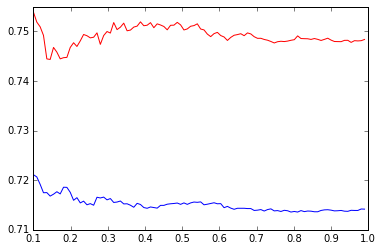

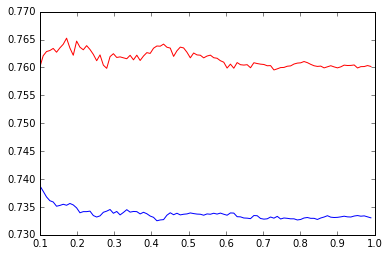

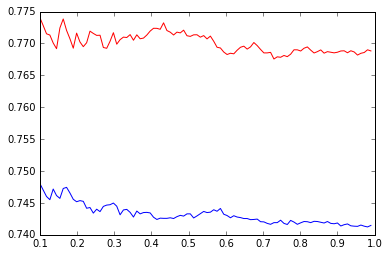

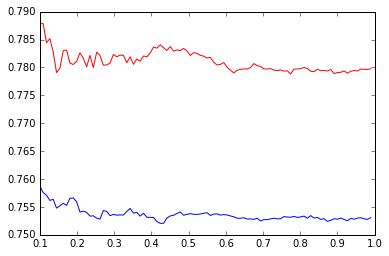

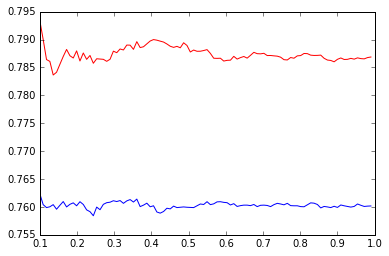

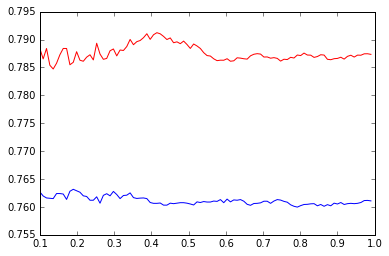

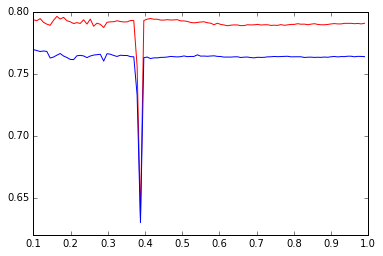

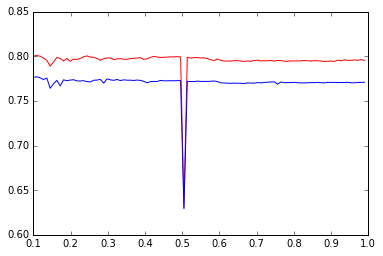

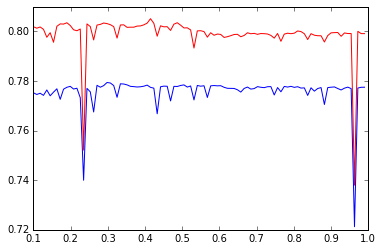

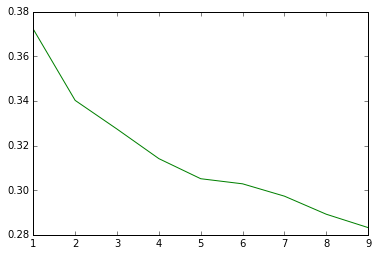

[0.37209344299973973,
 0.34021179243119087,
 0.32736622912435226,
 0.31412190980270183,
 0.30512429530559787,
 0.30284073973946629,
 0.29731246545446471,
 0.28921639034670177,
 0.28322454437210975]

In [169]:
for i in range(len(degrees)):
    plt.plot(train_data_ratios,train_success_rates_matrix[i],color='red')
    plt.plot(train_data_ratios,test_success_rates_matrix[i],color='blue')
    plt.show()
    #plt.savefig("ratios"+degree+".png")

plt.plot(degrees,final_losses, color = 'green')
plt.show()
final_losses

### Distribution analysis

In [176]:
signal = np.empty([0,x_clean.shape[1]])
background = np.empty([0,x_clean.shape[1]])

for i in range(len(y)):
    if(y[i]==1):
        signal = np.vstack((signal,x_clean[i]))
    else:
        background = np.vstack((background,x_clean[i]))

signal.shape,background.shape

((34170, 18), (34170, 18))

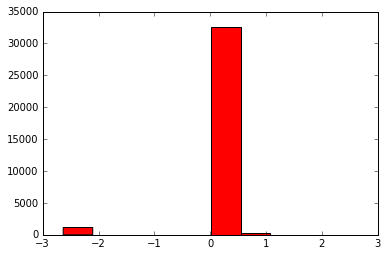

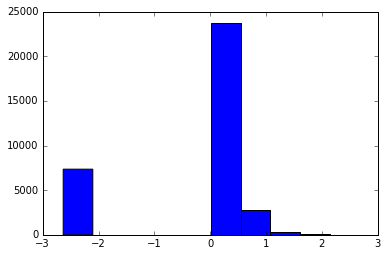

In [178]:

plt.hist(signal[:,0],color='red')
plt.show()
plt.hist(background[:,0],color='blue')
plt.show()

### Exportation

In [62]:


test_model_and_export(data_u,ids_u,best_w,best_degree)



(568238, 2)
['Id', 'Prediction']
